In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/home/digarza/cholla_dev/cholla-viz')

In [3]:
from ChollaSnap import *
from ChollaRun import *

In [4]:
plt.style.use("dstyle")
_ = plt.figure()
plt.style.use("dstyle")

<Figure size 432x288 with 0 Axes>

In [5]:
##############
def calc_velocity(data):
    data["vel_x"] = data["momentum_x"] / data["density"]
    data["vel_y"] = data["momentum_y"] / data["density"]
    data["vel_z"] = data["momentum_z"] / data["density"]
    data["vel_mag"] = np.sqrt(data["vel_x"]**2 + data["vel_y"]**2 + data["vel_z"]**2)

def req_velocity(data, head):
    return ["momentum_x", "momentum_y", "momentum_z", "density"]

kwarg_fn = None

velocity_calc = ChollaValueCalc(calc_velocity, req_velocity, kwarg_fn)

##############
def calc_press(data, DE=None, gamma=None):
    if DE:
        data["pressure"] = data["Energy"]*(gamma-1.0)
    else:
        data["pressure"] = (data["Energy"] - 0.5*data["density"]*(data["vel_mag"]**2)) * (gamma - 1.0)

def req_press(data, head):
    return ["vel_mag", "Energy", "density"]

def kwargs_press(kwargs, data, head):
    kwargs["gamma"] = head["gamma"]
    kwargs["DE"] = None

press_calc = ChollaValueCalc(calc_press, req_press, kwargs_press)


##############
def calc_intenergy(data, DE=None, gamma=None):
    
    if DE:
        data["int_energy"] = data["Energy"]/data["density"]
    else:
        data["int_energy"] = data["pressure"]/data["density"]/(gamma - 1.0)

def req_intenergy(data, head):
    DE = 0
    if DE:
        return ["density", "Energy"]
    else:
        return ["pressure", "density", "Energy"]

def kwargs_intenergy(kwargs, data, head):
    kwargs["gamma"] = head["gamma"]
    kwargs["DE"] = None

intenergy_calc = ChollaValueCalc(calc_intenergy, req_intenergy, kwargs_intenergy)


##############
cholla_calcs = [velocity_calc, press_calc, intenergy_calc]

In [14]:
tot_nsnap = 133
nblock = 4
base_dir =  "/data/users/digarza/cholla_exs/2D_Test/sod"
namebase = "h5"
img_dir = "/imgs/density" # where to store images relative to base_dir

ch_run = ChollaRun(base_dir, tot_nsnap, namebase, nblock, img_dir=img_dir)

In [15]:
nSnap1, nSnap2 = 0, 1
dataPath = ch_run.dataPath
namebase = ch_run.namebase
nBoxes = ch_run.nBoxes

ch_snap1 = ChollaSnap(dataDir=dataPath, nSnap=nSnap1, namebase=namebase, 
                     nBoxes=nBoxes)

ch_snap2 = ChollaSnap(dataDir=dataPath, nSnap=nSnap2, namebase=namebase, 
                     nBoxes=nBoxes)

keys = ["Energy", "density", "momentum_x", "momentum_y", "momentum_z"]
ch_snap1.load_data(keys)
ch_snap1.calc_vals(cholla_calcs)

ch_snap2.load_data(keys)
ch_snap2.calc_vals(cholla_calcs)

In [16]:
def plot_density_2D_comp(data1, head1, data2, head2, plt_kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    density1 = data1["density"][:,:,0].T
    density2 = data2["density"][:,:,0].T
    density = [density1, density2]
    
    t1 = head1["t"][0]
    t2 = head2["t"][0]
    all_t = [t1,t2]

    fig, ax = plt.subplots(nrows=1, ncols=2)

    for i in range(2):
        im = ax[i].imshow(density[i], vmin=0, vmax=1)

        ax[i].set_xlim(0, head1["dims"][0] - 1)
        ax[i].set_ylim(0, head1["dims"][1] - 1)

        ax[i].set_xlabel("X (cells)")
        ax[i].set_title(f"t = {all_t[i]:.4f}", fontsize=24)
    
    
    fig.subplots_adjust(right=0.8)
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    ax[1].get_yaxis().set_ticks([])
    
    ax[0].set_ylabel("Y (cells)")
    
    fig.suptitle("Density")
    plt.tight_layout()
    plt.subplots_adjust(top=1.3)
    
    if plt_kwargs.get("imgfout"):
        plt.savefig(plt_kwargs["imgfout"])
    if plt_kwargs.get("show"):
        plt.show()
    plt.close()

In [17]:
def plot_density_1D_comp(data1, head1, data2, head2, plt_kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    density1 = data1["density"][:,0,0].T
    density2 = data2["density"][:,0,0].T
    density = [density1, density2]
    
    t1 = head1["t"][0]
    t2 = head2["t"][0]
    all_t = [t1,t2]

    fig, ax = plt.subplots(nrows=1, ncols=2)

    for i in range(2):
        ax[i].plot(density[i])

        ax[i].set_xlim(0, head1["dims"][1] - 1)
        ax[i].set_ylim(0, 1)

        ax[i].set_xlabel("X (cells)")
        ax[i].set_title(f"t = {all_t[i]:.4f}", fontsize=24)
    
    ax[0].set_ylabel("Density")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.7)
    
    if plt_kwargs.get("imgfout"):
        plt.savefig(plt_kwargs["imgfout"])
    if plt_kwargs.get("show"):
        plt.show()
    plt.close()

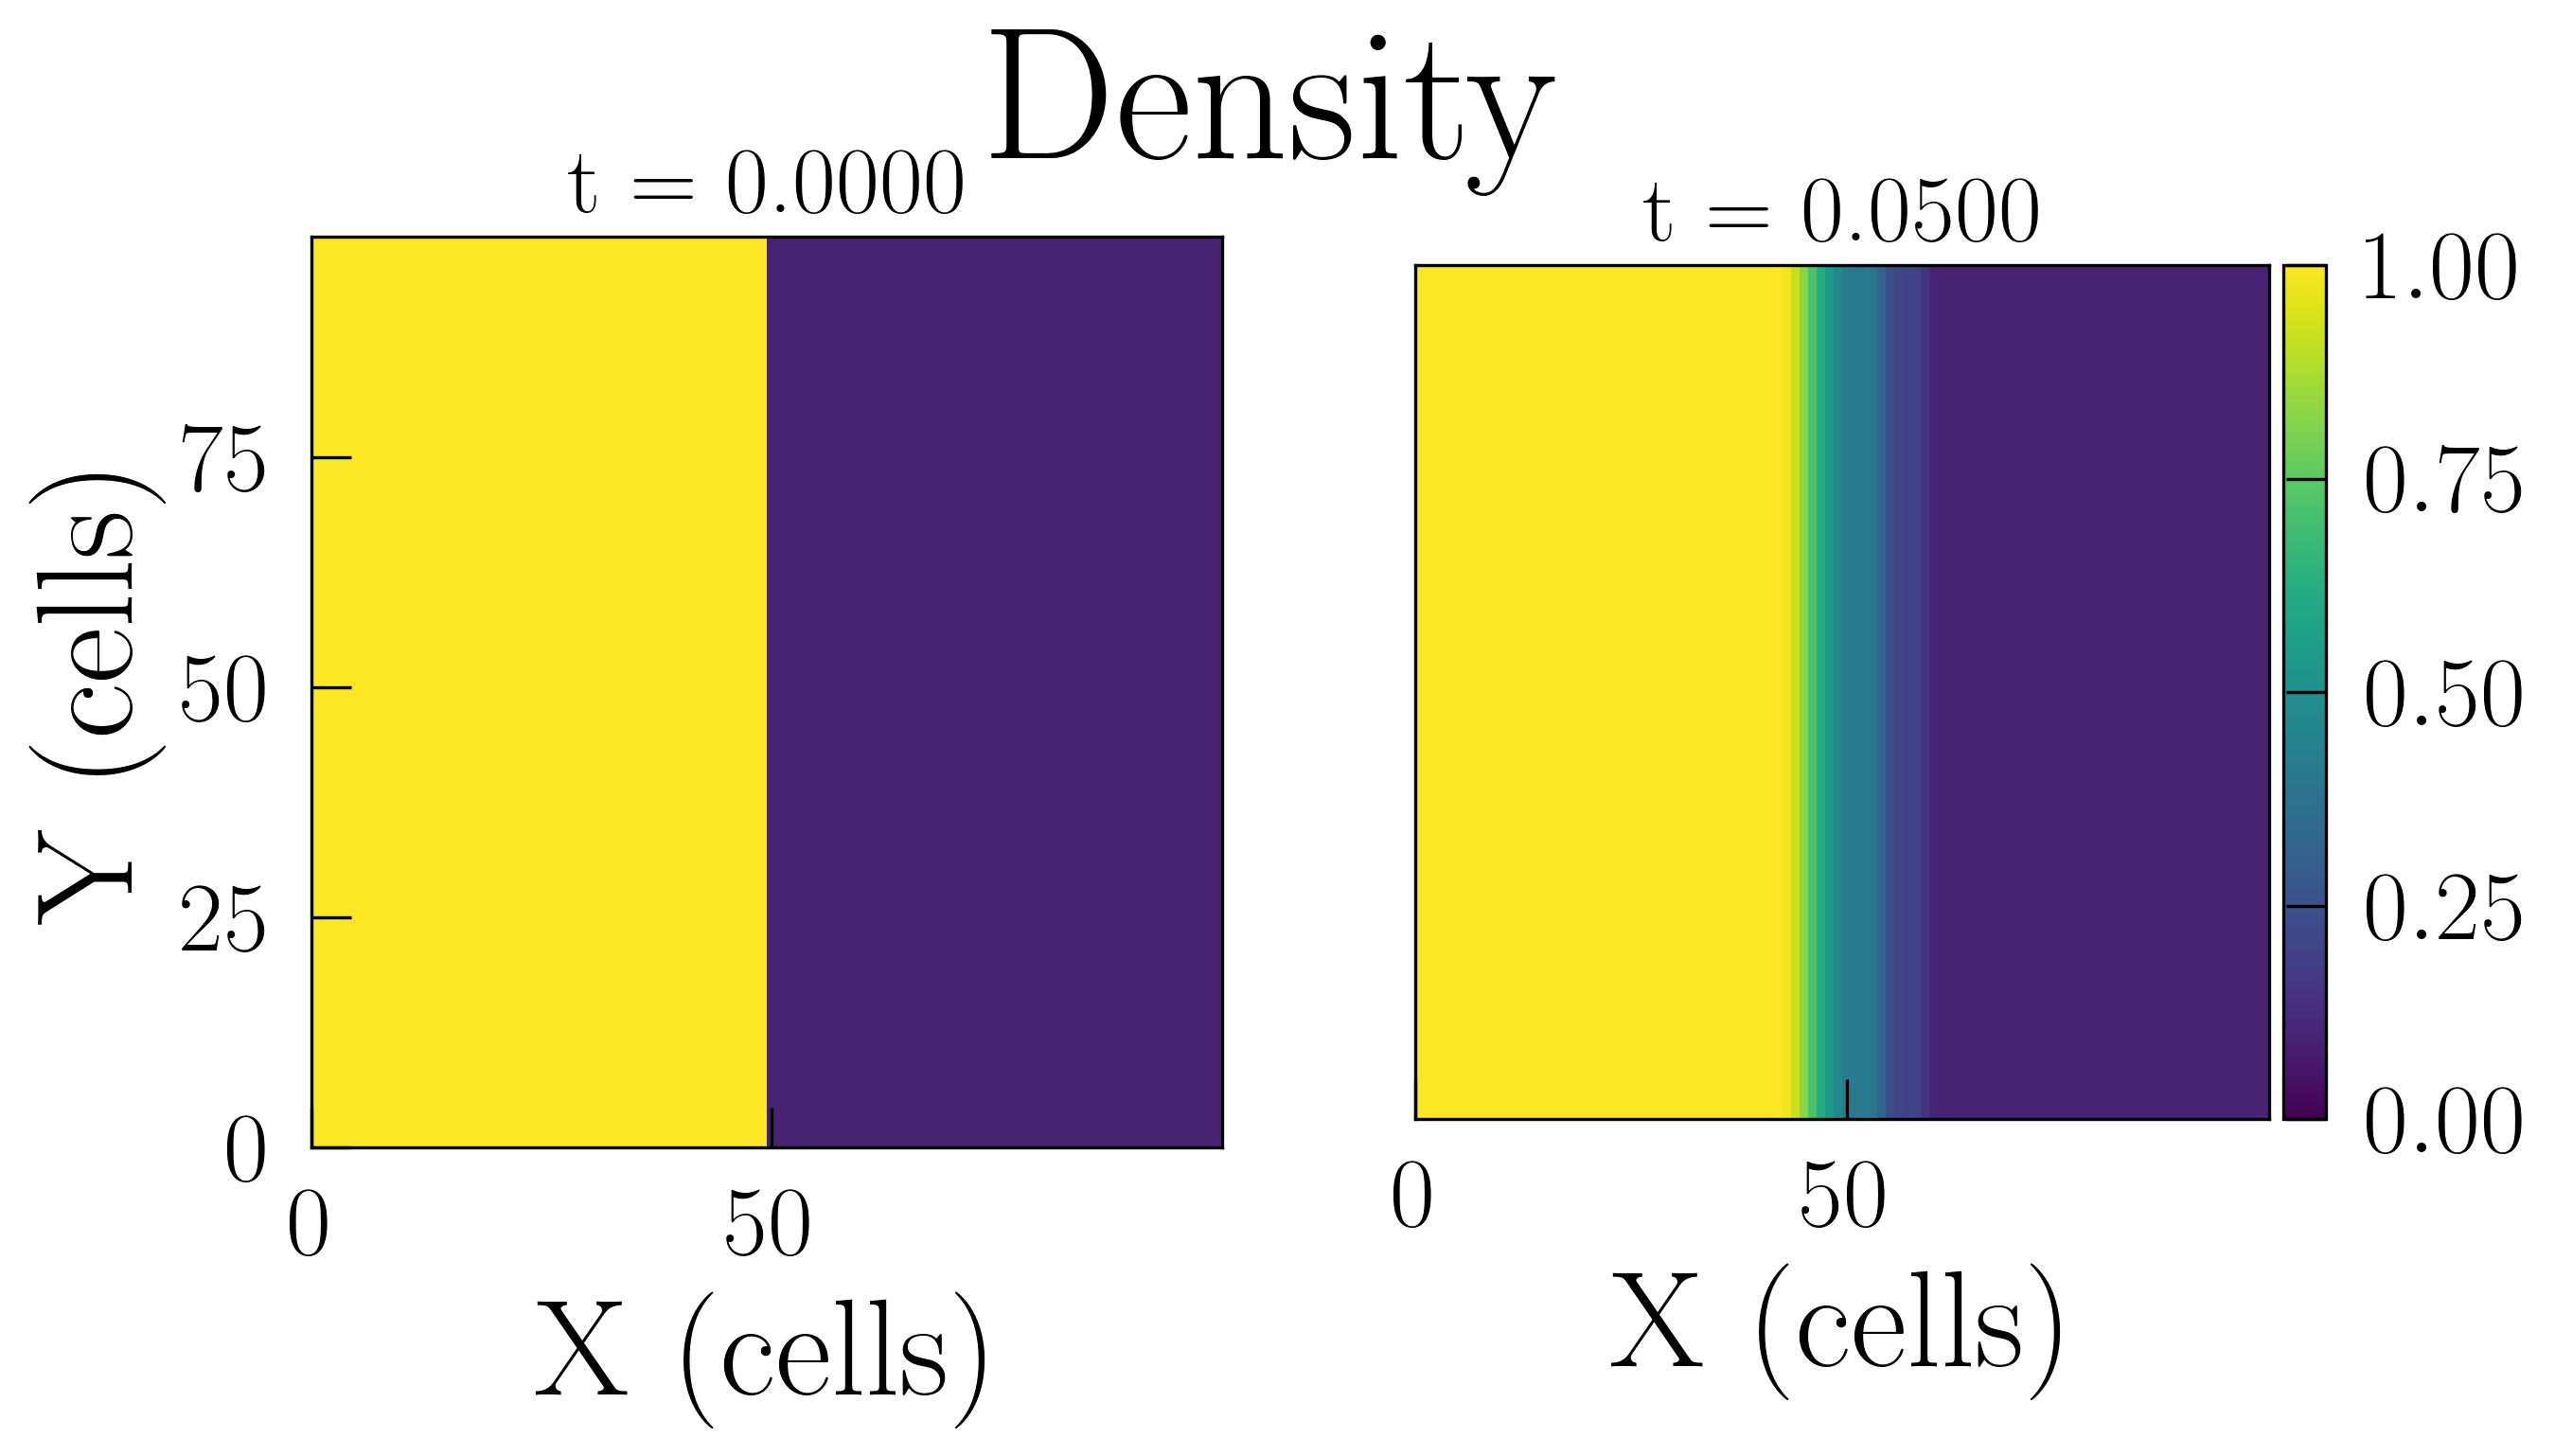

In [18]:
kwargs = {"show": True}
plot_density_2D_comp(ch_snap1.data, ch_snap1.head, ch_snap2.data, ch_snap2.head, kwargs)

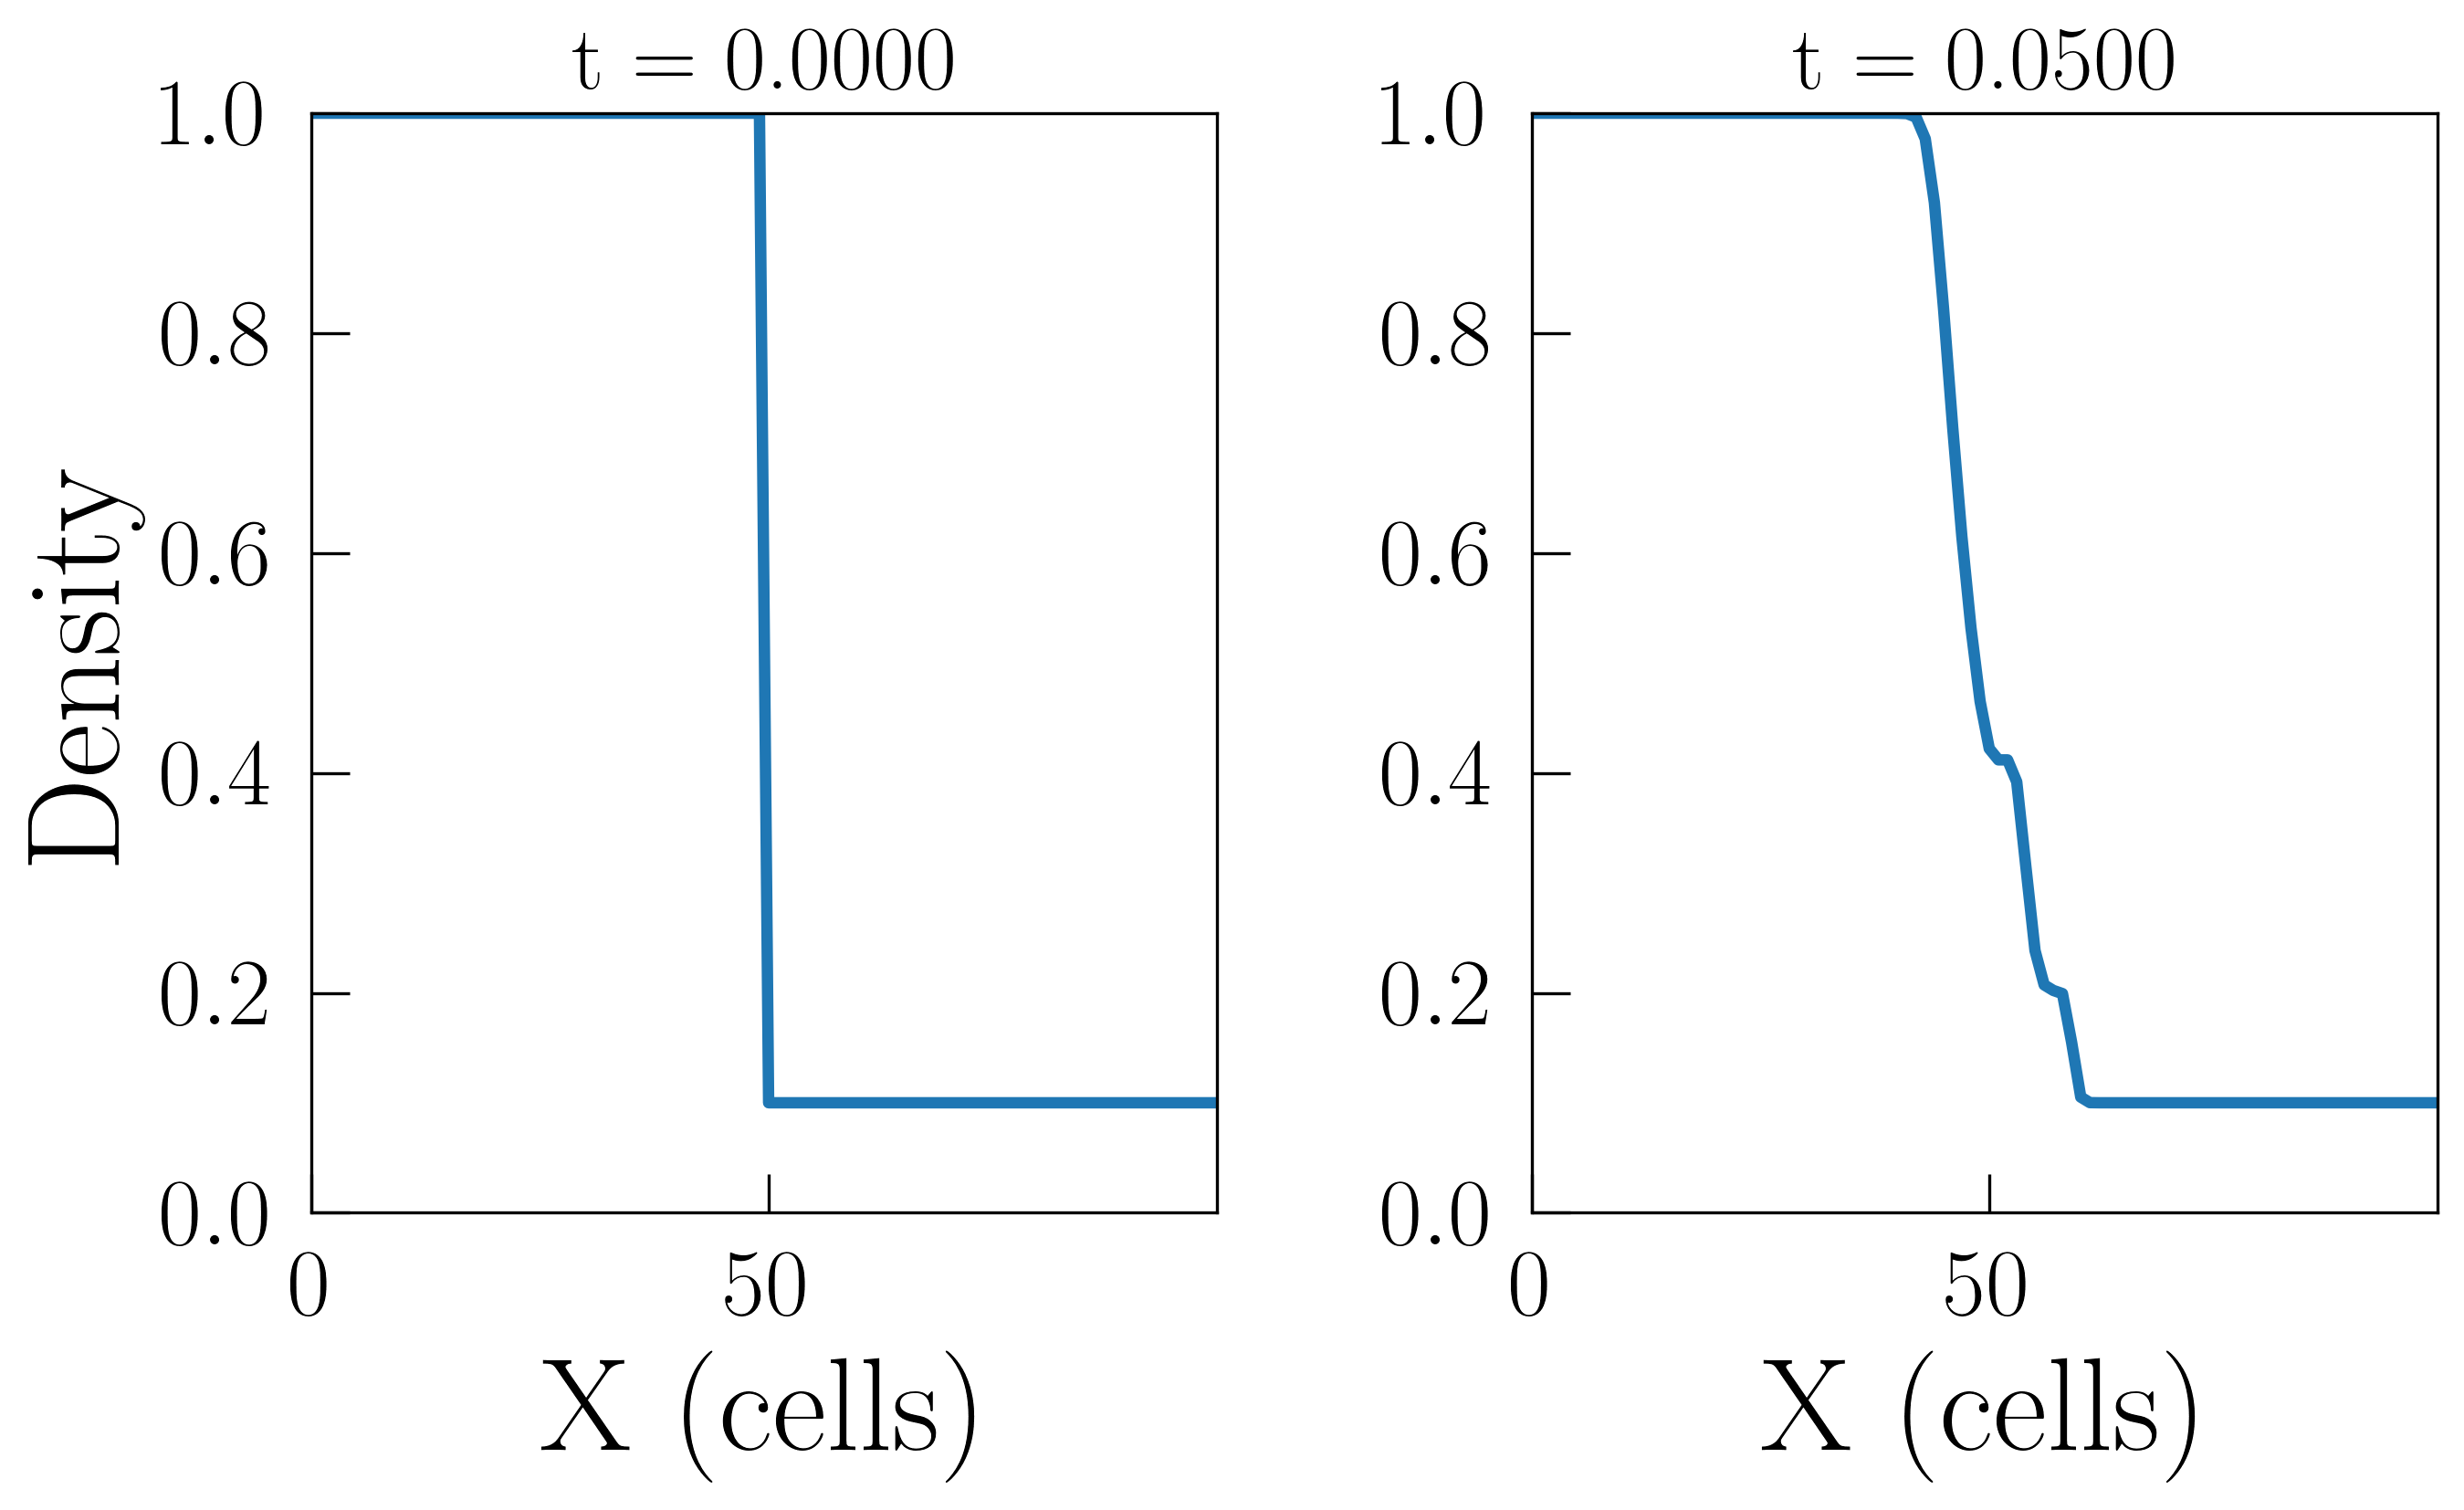

In [19]:
kwargs = {"show": True}
plot_density_1D_comp(ch_snap1.data, ch_snap1.head, ch_snap2.data, ch_snap2.head, kwargs)